In [1]:
import os
import polars as pl
import polars.selectors as cs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [2]:
# adding this because of a bug. See similar issue here: https://github.com/pypa/setuptools/issues/3297
os.environ["SETUPTOOLS_USE_DISTUTILS"] = "stdlib"

In [4]:
MLFLOW_TRACKING_URI = "http://localhost:5001"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("credit-card-fraud-detection")

2024/01/23 14:34:16 INFO mlflow.tracking.fluent: Experiment with name 'credit-card-fraud-detection-v1' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1706020455271, experiment_id='2', last_update_time=1706020455271, lifecycle_stage='active', name='credit-card-fraud-detection-v1', tags={}>

<h2> <class="myText"> Notebook links </h2>
<p> <class="myText"> <em> (Note, these links don't tend to work when you open the notebook in PyCharm, for example. Open the notebook in your browser to navigate the notebook using the links)</em> </p>

<p> 1. <a href="#data_preparation">Data preparation</a></p>
<p> 2. <a href="#validation_framework_setup">Setting up the validation framework</a></p>
<p> 3. <a href="#eda">Exploratory data analysis</a></p>
<ul>
    <li><a href="#feature_importance">Feature importance</a></li>
</ul>
<p> 4. <a href="#encoding">One-hot encoding</a></p>
<p> 5. <a href="#model_training">Model training</a></p>
<ul>
    <li><a href="#random_forest">Random Forest</a></li>
</ul>
<p> 6. <a href="#final_training">Train the final model</a></p>

# Data preparation <a name = "data_preparation"></a>

In [16]:
df = (
    pl.scan_csv("../data/creditcard_2023.csv")
    .select(pl.all().shrink_dtype().name.to_lowercase())
    .rename({"class": "is_fraud"})
).collect()

In [17]:
df.describe()

describe,id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,is_fraud
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0,568630.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",284314.5,-2.9561e-10,4.5765e-10,-8.5887e-11,-2.5639e-11,4.1151e-10,-3.4432e-10,7.5353e-10,9.0302e-11,-1.6306e-11,8.0231e-12,-2.2646e-10,-6.7698e-11,2.1025e-10,-2.9896e-10,-2.6961e-10,-3.6392e-10,-5.2388e-11,-9.1236e-11,1.5974e-10,-4.5541e-10,-5.0214e-10,-7.0569e-10,1.0317e-9,-2.0437e-10,7.0265e-11,-1.9763e-10,4.6969e-10,8.8740e-13,12041.958008,0.5
"""std""",164149.486122,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,6919.644531,0.5
"""min""",0.0,-3.495584,-49.966572,-3.18376,-4.951222,-9.952785,-21.111109,-4.35184,-10.756342,-3.751919,-3.163276,-5.954723,-2.020399,-5.955227,-2.107417,-3.861813,-2.214513,-2.484938,-2.421949,-7.804988,-78.147835,-19.382523,-7.734798,-30.29545,-4.067968,-13.612633,-8.22697,-10.498633,-39.035244,50.009998,0.0
"""25%""",142157.0,-0.565286,-0.48668,-0.649299,-0.656021,-0.293496,-0.445872,-0.283533,-0.192257,-0.56875,-0.590101,-0.701451,-0.831134,-0.696668,-0.873206,-0.621249,-0.716267,-0.619494,-0.556049,-0.565308,-0.35024,-0.166441,-0.49049,-0.237629,-0.65158,-0.554149,-0.631895,-0.304961,-0.231878,6054.859863,0.0
"""50%""",284315.0,-0.093636,-0.135894,0.000354,-0.073759,0.081089,0.078719,0.233367,-0.114523,0.092527,0.262617,-0.041049,0.162052,0.017611,0.230502,-0.039254,0.134027,0.271641,0.087296,-0.025978,-0.123376,-0.037431,-0.027327,-0.059689,0.015903,-0.008192,-0.011891,-0.172911,-0.01393,12030.169922,1.0
"""75%""",426472.0,0.832658,0.343556,0.628539,0.707006,0.439738,0.497788,0.525955,0.047299,0.559266,0.592462,0.747773,0.744672,0.685606,0.751822,0.665407,0.655607,0.518225,0.544389,0.560118,0.248217,0.14798,0.463887,0.155716,0.70074,0.550015,0.672889,0.334024,0.409591,18036.330078,1.0
"""max""",568629.0,2.229046,4.361865,14.125834,3.201535,42.716892,26.168402,217.873032,5.95804,20.270061,31.72271,2.513573,17.913557,7.187486,19.169544,14.532202,46.652905,6.994124,6.783716,3.831672,29.872812,8.08708,12.632511,31.707626,12.965639,14.62151,5.623285,113.231094,77.255936,24039.929688,1.0


# Setting up the validation framework <a name = "validation_framework_setup"></a>

In [18]:
df_full_train, df_test = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=11
)
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, shuffle=True, random_state=11
)

# y_train = df_train.select("class").to_numpy().flatten()
y_train = df_train.select("is_fraud").to_pandas().values
y_val = df_val.select("is_fraud").to_numpy().flatten()
y_test = df_test.select("is_fraud").to_numpy().flatten()

df_train = df_train.drop("is_fraud")
df_val = df_val.drop("is_fraud")

# Exploratory data analysis <a name = "eda"></a>

In [19]:
# check for nulls
df.null_count()

id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,is_fraud
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Feature importance <a name = "feature_importance"></a>

In [20]:
categorical = df_train.select(cs.string()).columns
numerical = df_train.select(cs.numeric()).columns

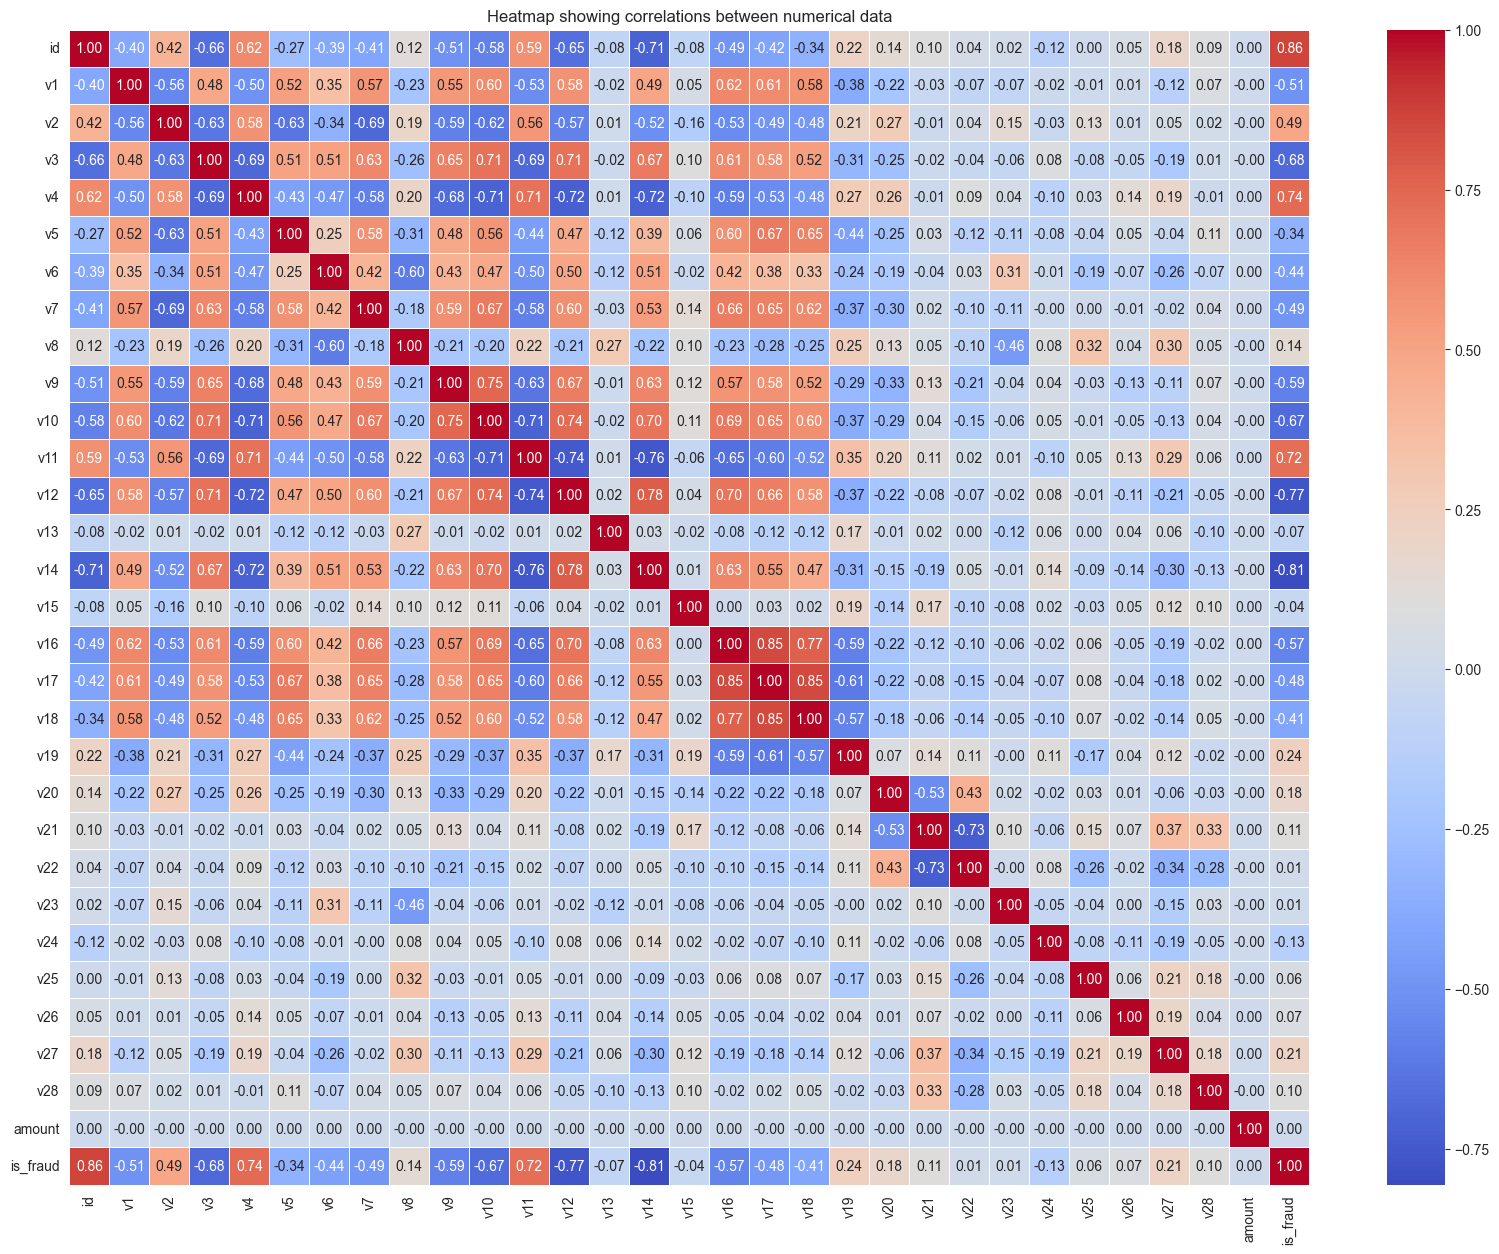

In [21]:
# check correlation coefficients between columns. Visualise this in a heatmap by creating a correlation matrix between all the numerical features
plt.figure(figsize=(20, 15))
sns.heatmap(
    df_full_train[numerical + ["is_fraud"]].corr(),
    annot=True,
    linewidths=0.5,
    cmap="coolwarm",
    fmt=".2f",
    xticklabels=df_full_train[numerical + ["is_fraud"]].columns,
    yticklabels=df_full_train[numerical + ["is_fraud"]].columns,
)
plt.title("Heatmap showing correlations between numerical data")
plt.show()

In [22]:
df_train.select(categorical).head()

shape: (0, 0)
┌┐
╞╡
└┘

In [23]:
df.select(numerical).head()

id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount
i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.98702,0.293438,-0.941386,0.54902,1.804879,0.215598,0.512307,0.333644,0.12427,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.12628,-0.434824,-0.08123,-0.151045,17982.099609
1,0.9851,-0.356045,0.558056,-0.429654,0.27714,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.40381,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.19009,0.296503,-0.248052,-0.064512,6531.370117
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.00502,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.540039
3,-0.152152,-0.508959,1.74684,-1.090178,0.249486,1.143312,0.518269,-0.06513,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.34506,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.51595,-0.165316,0.048424,5384.439941
4,-0.20682,-0.16528,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.21266,1.049921,0.968046,-1.203171,1.029577,1.43931,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.969727


In [24]:
# note, we have included numerical variables as well here, but the DictVectorizer is smart enough to recognise that
dicts_train = df_train.select(categorical + numerical).to_dicts()

In [25]:
dicts_val = df_val.select(categorical + numerical).to_dicts()

# Model training <a name = "model_training"></a>

### Random Forest <a name = "random_forest"></a>

In [28]:
params = {
    "n_estimators": scope.int(hp.quniform("n_estimators", 10, 201, 10)),
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "random_state": 11,
    "n_jobs": -1,
}
model = RandomForestClassifier(**params)
type(model)

sklearn.ensemble._forest.RandomForestClassifier

In [26]:
# hyperparameter running let's tune the max_depth parameter first


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("developer", "james")
        mlflow.set_tag("model", "randomforestclassifier")

        # mlflow.log_param("train-data-path", "data/creditcard_2023.csv")
        mlflow.log_param("data-path", "data/creditcard_2023.csv")
        mlflow.log_params(params)

        pipeline = make_pipeline(
            DictVectorizer(sparse=False), RandomForestClassifier(**params)
        )

        pipeline.fit(dicts_train, y_train.ravel())
        y_pred = pipeline.predict_proba(dicts_val)[0:, 1]
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        mlflow.log_metric("rmse", rmse)

        mlflow.sklearn.log_model(pipeline, artifact_path="model")

    return {"loss": rmse, "status": STATUS_OK}

In [27]:
search_space = {
    "n_estimators": scope.int(hp.quniform("n_estimators", 10, 201, 10)),
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "random_state": 11,
    "n_jobs": -1,
}
best_result = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=4, trials=Trials()
)

100%|██████████| 4/4 [02:27<00:00, 36.84s/trial, best loss: 0.01278194244236241]


# Train final model training <a name = "model_training"></a>

In [ ]:
# train our model with the optimum parameters and enable autologging to see more parameter values

params = {
    "n_estimators": 170,
    "max_depth": 36,
    "random_state": 11,
}

mlflow.sklearn.autolog()

with mlflow.start_run():
    mlflow.set_tag("developer", "james")
    mlflow.set_tag("model", "randomforestclassifier")

    pipeline = make_pipeline(
        DictVectorizer(sparse=False), RandomForestClassifier(**params)
    )

    pipeline.fit(dicts_train, y_train.ravel())
    y_pred = pipeline.predict(dicts_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric("rmse", rmse)